In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [12]:
data = pd.read_csv("final_with_weather.csv")

In [13]:
data.drop(['Month'], axis =1, inplace= True)

In [14]:
data.set_index("pickuptime", inplace= True)

In [15]:
data.head()

,temp,wind_speed,holiday,precip_in,Hour,Day,green,yellow,total,clear,clouds,fog,rain,snow,thunderstorm
pickuptime,,,,,,,,,,,,,,,
2014-01-01 01:00:00-05:00,268.90,2.0,1,0.0,1,2,2595,30887,33482,1,0,0,0,0,0
2014-01-01 02:00:00-05:00,268.48,3.0,1,0.0,2,2,2630,33650,36280,1,0,0,0,0,0
2014-01-01 03:00:00-05:00,268.33,3.0,1,0.0,3,2,2409,30745,33154,1,0,0,0,0,0
2014-01-01 04:00:00-05:00,268.10,3.0,1,0.0,4,2,2276,26244,28520,1,0,0,0,0,0
2014-01-01 05:00:00-05:00,268.02,1.0,1,0.0,5,2,1911,18792,20703,1,0,0,0,0,0


In [16]:
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['green', 'yellow', 'total'], axis =1, inplace = True)

In [9]:
np.random.seed(7)

In [10]:

def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [17]:
features_and_target = pd.concat([data, num_pickups], axis = 1)

In [12]:
features_and_target.shape

(32844, 5)

In [13]:
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 23

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]

reframed.head()

,var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var5(t-22),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
23,0.0,0.000000,0.333333,1.0,0.596227,0.0,0.043478,0.333333,1.0,0.646069,...,0.0,0.956522,0.333333,1.0,0.267555,0.0,1.000000,0.333333,1.0,0.204140
24,0.0,0.043478,0.333333,1.0,0.646069,0.0,0.086957,0.333333,1.0,0.590384,...,0.0,1.000000,0.333333,1.0,0.204140,0.0,0.000000,0.500000,0.0,0.148616
25,0.0,0.086957,0.333333,1.0,0.590384,0.0,0.130435,0.333333,1.0,0.507838,...,0.0,0.000000,0.500000,0.0,0.148616,0.0,0.043478,0.500000,0.0,0.092041
26,0.0,0.130435,0.333333,1.0,0.507838,0.0,0.173913,0.333333,1.0,0.368592,...,0.0,0.043478,0.500000,0.0,0.092041,0.0,0.086957,0.500000,0.0,0.060690
27,0.0,0.173913,0.333333,1.0,0.368592,0.0,0.217391,0.333333,1.0,0.219584,...,0.0,0.086957,0.500000,0.0,0.060690,0.0,0.130435,0.500000,0.0,0.041826


In [14]:
reframed.shape

(32821, 120)

In [15]:

# split into train and test sets# split i # split  
values = reframed.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 115) 26280 (26280,)
(26280, 23, 5) (26280,) (6541, 23, 5) (6541,)


In [16]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6541 samples
Epoch 1/100
 - 4s - loss: 0.0959 - val_loss: 0.0522
Epoch 2/100
 - 4s - loss: 0.0611 - val_loss: 0.0410
Epoch 3/100
 - 4s - loss: 0.0429 - val_loss: 0.0289
Epoch 4/100
 - 4s - loss: 0.0364 - val_loss: 0.0277
Epoch 5/100
 - 4s - loss: 0.0336 - val_loss: 0.0253
Epoch 6/100
 - 4s - loss: 0.0313 - val_loss: 0.0227
Epoch 7/100
 - 4s - loss: 0.0294 - val_loss: 0.0230
Epoch 8/100
 - 4s - loss: 0.0276 - val_loss: 0.0222
Epoch 9/100
 - 4s - loss: 0.0259 - val_loss: 0.0207
Epoch 10/100
 - 4s - loss: 0.0252 - val_loss: 0.0198
Epoch 11/100
 - 4s - loss: 0.0245 - val_loss: 0.0192
Epoch 12/100
 - 4s - loss: 0.0239 - val_loss: 0.0191
Epoch 13/100
 - 4s - loss: 0.0236 - val_loss: 0.0188
Epoch 14/100
 - 4s - loss: 0.0232 - val_loss: 0.0189
Epoch 15/100
 - 4s - loss: 0.0228 - val_loss: 0.0191
Epoch 16/100
 - 4s - loss: 0.0224 - val_loss: 0.0191
Epoch 17/100
 - 4s - loss: 0.0221 - val_loss: 0.0189
Epoch 18/100
 - 4s - loss: 0.0218 - val_loss: 0.0189
Epoch 

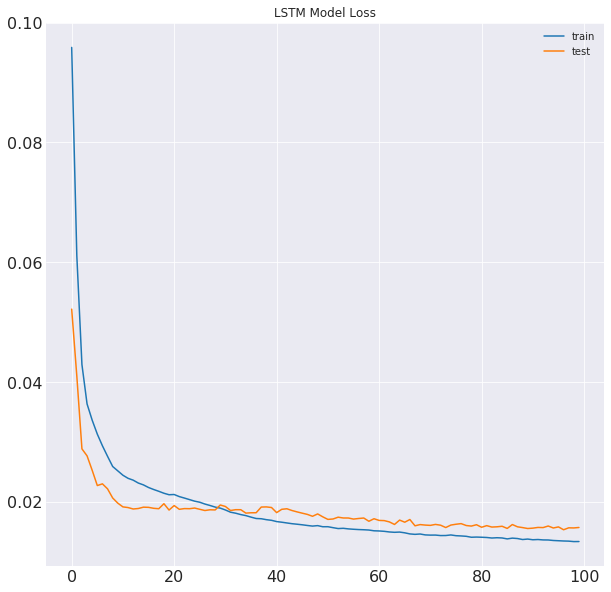

In [17]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [18]:
# make a prediction# make a  
yhat = model.predict(test_X)

In [19]:
test_X.shape

(6541, 23, 5)

In [20]:
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

In [21]:
test.shape

(6541, 120)

In [22]:
test_X.shape

(6541, 115)

In [23]:

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 115:119], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 115:119], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [24]:
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

In [25]:
# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

R2:   0.9649437383125776


In [26]:
# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

MAE:  883.5644


In [27]:
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

RMSE: 1232.697600792668


In [28]:
results = pd.DataFrame()
results['prediction'] = inv_yhat
results['actual'] = inv_y

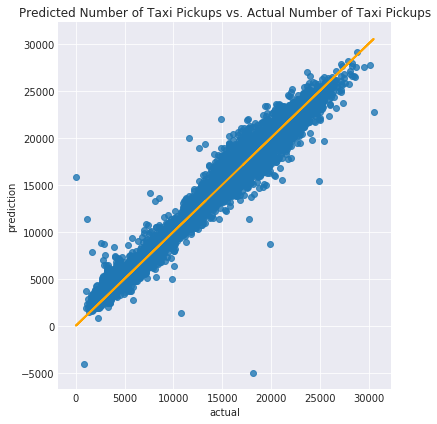

In [29]:
import seaborn as sns
sns.lmplot(x='actual',y='prediction',data=results,fit_reg=False, size=6)
plt.plot(results['actual'], results['actual'], color="orange", linewidth=2)

plt.title("Predicted Number of Taxi Pickups vs. Actual Number of Taxi Pickups")
plt.tight_layout()

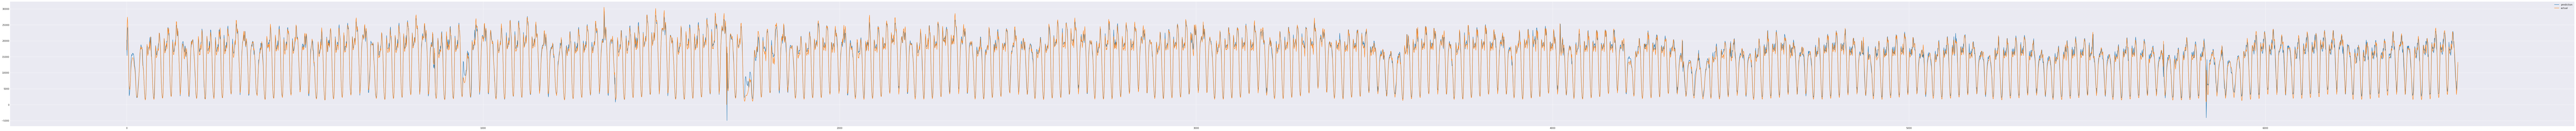

In [30]:
results.plot(figsize=(200,10));

In [31]:
np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100

25.296247005462646

In [18]:
features_and_target.head()

,temp,wind_speed,holiday,precip_in,Hour,Day,clear,clouds,fog,rain,snow,thunderstorm,total
pickuptime,,,,,,,,,,,,,
2014-01-01 01:00:00-05:00,268.90,2.0,1,0.0,1,2,1,0,0,0,0,0,33482
2014-01-01 02:00:00-05:00,268.48,3.0,1,0.0,2,2,1,0,0,0,0,0,36280
2014-01-01 03:00:00-05:00,268.33,3.0,1,0.0,3,2,1,0,0,0,0,0,33154
2014-01-01 04:00:00-05:00,268.10,3.0,1,0.0,4,2,1,0,0,0,0,0,28520
2014-01-01 05:00:00-05:00,268.02,1.0,1,0.0,5,2,1,0,0,0,0,0,20703
